In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import PorterStemmer
from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.metrics.pairwise import cosine_similarity
import re
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import pickle
import streamlit as st
import matplotlib.pyplot as plt
from itertools import cycle

In [11]:
def tokenize_stem(series):

    tokenizer =TreebankWordTokenizer()
    stemmer = PorterStemmer()
    series = series.apply(lambda x: x.replace("\n", ' '))
    series = series.apply(lambda x: tokenizer.tokenize(x))
    series = series.apply(lambda x: [stemmer.stem(w) for w in x])
    series = series.apply(lambda x: ' '.join(x))
    return series

def display_topics(model, feature_names, no_top_words, topic_names=None):
    '''
    displays topics and returns list of toppics
    '''
    topic_list = []
    for i, topic in enumerate(model.components_):
        if not topic_names or not topic_names[i]:
            print("\nTopic ", i)
        else:
            print("\nTopic: '",topic_names[i],"'")

        print(", ".join([feature_names[k]
                       for k in topic.argsort()[:-no_top_words - 1:-1]]))
        topic_list.append(", ".join([feature_names[k]
                       for k in topic.argsort()[:-no_top_words - 1:-1]]))
    return model.components_, topic_list

def return_topics(series, num_topics, no_top_words, model, vectorizer):
    '''
    returns document_topic matrix and topic modeling model
    '''
    
    #turn job into series
    series = tokenize_stem(series)
    
    #transform series into corpus
    ex_label = [e[:30]+"..." for e in series]
    
    #set vectorizer ngrams = (2,2)
    vec = vectorizer(stop_words = 'english')

    doc_word = vec.fit_transform(series)

    #build model
    def_model = model(num_topics)
    def_model = def_model.fit(doc_word)
    doc_topic = def_model.transform(doc_word)

    model_components, topic_list = display_topics(def_model, vec.get_feature_names(), no_top_words)
    return def_model.components_, doc_topic, def_model, vec, topic_list#, topics


def process_data():
    '''
    uses the functions above to read in files, model, and return a topic_document dataframe
    '''
    #read in jobs file and get descriptions
    df = pd.read_csv('indeed_scrape.csv')

    jobs_df = pd.DataFrame(zip(df['summary'], df['job_title']), columns = ['summary', 'job_title'])

    array, doc, topic_model, vec, topic_list  = return_topics(jobs_df['summary'],20, 10, TruncatedSVD, TfidfVectorizer)

    topic_df = pd.DataFrame(doc)
    topic_df.columns = ['Topic ' + str(i+1) for i in range(len(topic_df.columns)) ]

    topic_df['job'] = jobs_df.job_title
    topic_df.to_csv('topic_df.csv')
    return topic_df, topic_model, vec, topic_list

def predictive_modeling(df):
    '''
    fits, optimizes, and predicts job class based on topic modeling corpus
    '''
    X,y = df.iloc[:,0:-1], df.iloc[:, -1]
    X_tr, X_te, y_tr, y_te = train_test_split(X,y)

    param_grid = {'n_estimators': [100,300, 400, 500, 600], 'max_depth': [3,7,9, 11]}

    rfc = RandomForestClassifier(n_estimators = 500, max_depth = 9)
    rfc.fit(X_tr, y_tr)
    
    print('acc: ', np.mean(cross_val_score(rfc, X_tr, y_tr, scoring = 'accuracy', cv=5)))
    print('test_acc: ', accuracy_score(y_te, rfc.predict(X_te)))
    print(rfc.predict(X_te))
    return rfc

def predict_resume(topic_model, model, resume):
    '''
    transforms a resume based on the topic modeling model and return prediction probabilities per each job class
    '''
    doc = topic_model.transform(resume)
    return model.predict_proba(doc), model.classes_

def get_topic_classification_models():
    jobs_df, model, vec , topic_list= process_data()
    model_1 = predictive_modeling(jobs_df)
    return model, model_1, vec


#Plot probability of person belonging to a job class
def plot_user_probability():
    #plt.figure(figsize = (2.5,2.5))
    plt.barh(data['jobs'], data['probability'], color = 'r')
    plt.title('Percent Match of Job Type')
    plt.show()

#Plot where user fits in with other job clusters
def plot_clusters():
    X_train, pca_train, y_train, y_vals, pca_model = create_clusters()
    for i, val in enumerate(y_train.unique()):
        y_train = y_train.apply(lambda x: i if x == val else x)
    example = user_input
    doc = transform_user_resume(pca_model, example)

    plot_PCA_2D(pca_train, y_train, y_vals, doc)
    plt.show()

def create_clusters():
    #topic_df, model, vec, topic_list = process_data()
    pca = PCA(n_components=2)
    topic_df = pd.read_csv('topic_df.csv')
    #topic_df = pd.read_pickle('topic_df.pkl')
    X_train = topic_df.iloc[:, 1:-1]
    y_train = topic_df.iloc[:, -1]
    y_vals = y_train.unique()
    model = pca.fit(X_train)

    return X_train, model.transform(X_train), y_train, y_vals, model


def plot_PCA_2D(data, target, target_names, user_data):
    colors = cycle(['black','g','b','c','m','y','orange','w','aqua','yellow'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10,10))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label, edgecolors='gray')
    plt.scatter(user_data[0][0], user_data[0][1], s = 150, color = 'red')
    plt.title('Job Clusters (You are the Red Dot)')
    plt.xlabel('Communication Words')
    plt.ylabel('Education Words')
    plt.legend()

def transform_user_resume(pca_model, resume):
    '''
    take in resume and fit it according to both count vectorizer and PCA model
    '''
    #jobs_df, topic_model, vec, topic_list = process_data()
    vec = pickle.load(open('job_vec.sav', 'rb'))
    topic_model = pickle.load(open('topic_model.sav', 'rb'))

    doc = tokenize_stem(resume)
    doc = vec.transform(doc)
    doc = topic_model.transform(doc)
    doc = pd.DataFrame(doc)

    doc = pca_model.transform(doc)
    return doc
    

In [3]:
topic_model, classifier, vec= get_topic_classification_models()
topic_model_name = 'topic_model.sav'
classifier_name = 'classification_model.sav'
vec_name = 'job_vec.sav'
pickle.dump(topic_model, open(topic_model_name, 'wb'))
pickle.dump(classifier, open(classifier_name, 'wb'))
pickle.dump(vec, open(vec_name, 'wb'))


Topic  0
servic, custom, experi, school, high, provid, year, educ, teach, prefer

Topic  1
center, learn, place, great, children, safe, play, achieve, nurtur, environ

Topic  2
guest, servic, custom, room, greet, guests, welcom, food, provid, restaur

Topic  3
guest, place, great, serv, friendli, room, work, greet, worship, christian

Topic  4
place, great, custom, servic, humble, worship, christian, capit, grow, onli

Topic  5
high, school, diploma, equival, guest, patient, prefer, equivalent, year, center

Topic  6
experi, teach, educ, year, custom, finish, frame, plumb, trade, roof

Topic  7
construct, electr, frame, finish, trade, plumb, door, knowledg, experi, window

Topic  8
construct, util, underground, student, instal, design, knowledg, school, team, patient

Topic  9
driver, valid, licens, drive, record, teach, manag, insur, proof, good

Topic  10
student, door, finish, frame, window, plumb, trade, roof, trim, hvac

Topic  11
tim, job, type, contract, teach, clean, driver, s

c:\users\laure\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


acc:  0.1947217578218295
test_acc:  0.1590909090909091
['Preschool Teacher' 'Preschool Teacher' 'Preschool Teacher'
 'Preschool Teacher' 'Medical Assistant' 'Preschool Teacher'
 'Bandsaw Operator' 'Preschool Teacher' 'Preschool Teacher'
 'Bandsaw Operator' 'Infant/Toddler Teacher'
 'Front Desk Patient Coordinator' 'Network Administrator'
 'Part time Substitute Teacher' 'Intake Coordinator' 'Host'
 'Preschool Teacher' 'Preschool Teacher' 'Preschool Teacher'
 'Preschool Teacher' 'Preschool Teacher' 'Preschool Teacher'
 'Intersession Teacher' 'Preschool Teacher'
 'Patient Service Representative' 'Preschool Teacher' 'Intake Coordinator'
 'Preschool Teacher' 'Front of House Supervisor' 'Preschool Teacher'
 'Preschool Teacher' 'Preschool Teacher' 'Preschool Teacher'
 'Krispy Kreme - Now Hiring Retail Staff - All Shifts!! 786'
 'Intersession Teacher' 'Preschool Teacher'
 'Vino Volo Market Clerk/Barista' 'Preschool Teacher' 'Preschool Teacher'
 'Preschool Teacher' 'Guest Services Representativ

In [4]:
def main(skill_list, topic_model, predictor, vec):

    doc = tokenize_stem(skill_list)
    doc = vec.transform(doc)
    probabilities, classes = predict_resume(topic_model, predictor, doc)
    return classes, probabilities[0]*100

In [5]:
# Transform user's skill set 
user_input = 'communication presentation education'

user_input = re.sub('[^a-zA-Z0-9\.]', ' ', user_input)
user_input = user_input.lower()

user_input = pd.Series(user_input)

In [6]:
#load NLP + classification models created previously with indeed scrape data 

topic_model = pickle.load(open('topic_model.sav', 'rb'))
classifier = pickle.load(open('classification_model.sav', 'rb'))
vec = pickle.load(open('job_vec.sav', 'rb'))

In [7]:
classes, prob = main(user_input, topic_model, classifier, vec)

data = pd.DataFrame(zip(classes.T, prob.T), columns = ['jobs', 'probability'])
data.to_csv('job_probability_output.csv', encoding='utf-8')
data

,jobs,probability
0,2020-2021 High School Teaching Assistant,0.285505
1,2020-2021 Middle School Teaching Assistant,0.139417
2,APPRENTICE / JOURNEYMAN ROOFER,0.144867
3,APPRENTICE CARPENTER,0.131015
4,AWS Certified Solutions Architect,0.141664
...,...,...
557,Window Installation & Service Team Members,0.151586
558,Wood Shop Worker - Trainee,0.134673
559,Wood Worker Trainee,0.137223
560,Youth Peer Mentor (The Source),0.139315


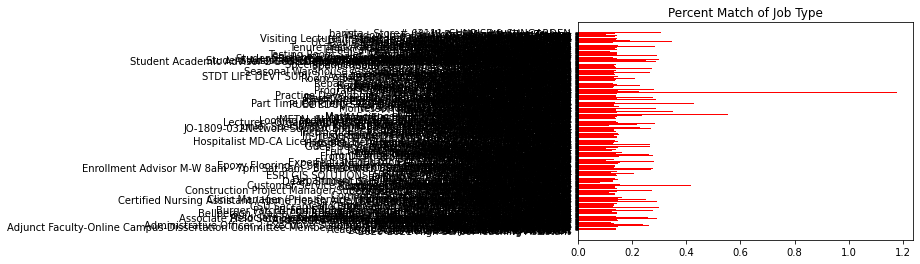

In [8]:
plot_user_probability()

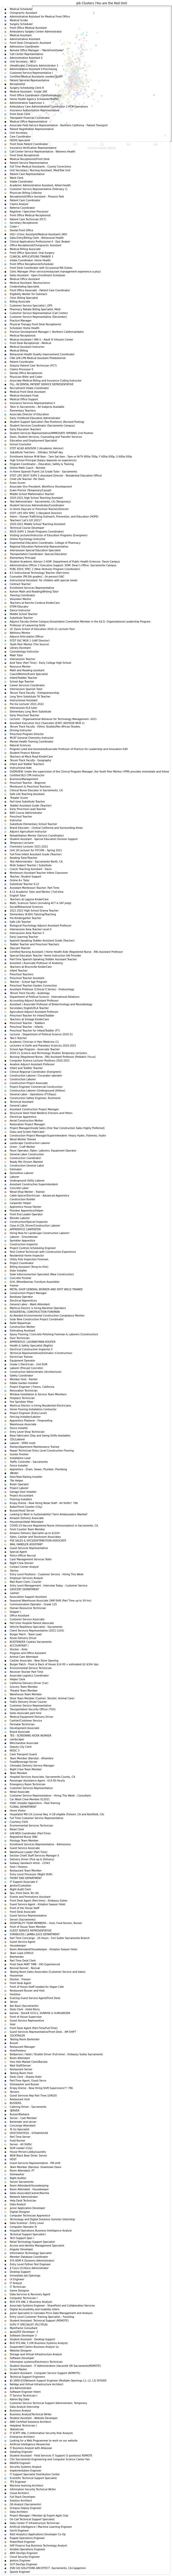

In [9]:
plot_clusters() # with legend

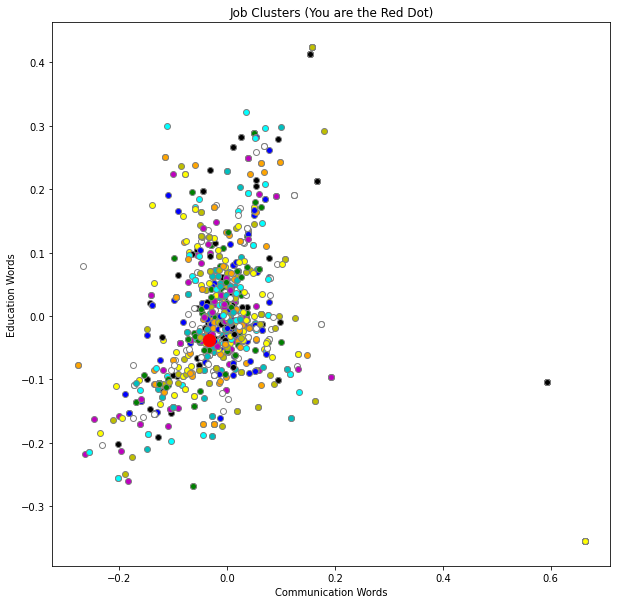

In [12]:
plot_clusters() # without a legend